In [1]:
# Import basic modules
import numpy as np
import pandas as pd
pd.options.display.max_columns = 1000
import matplotlib.pyplot as plt
import seaborn as sns
import os
import category_encoders as ce

# Import learning modules
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn import linear_model, preprocessing
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer
from sklearn.pipeline import make_pipeline
import xgboost as xgb
from xgboost import XGBRegressor
import lightgbm as lgb
from bayes_opt import BayesianOptimization
from catboost import CatBoostClassifier, cv, Pool

In [2]:
# For EDA - scatter plots of each independent variable to dependent variable
def scatterplots(columns, y_col, data, ncol=None, figsize=(15,8)) :
    if ncol == None:
        ncol = len(columns)
    nrow = int(np.ceil(len(columns) / ncol))
    fig, axes = plt.subplots(nrow, ncol, figsize=figsize, squeeze=False)
    fig.subplots_adjust(wspace=0.5, hspace=0.6)
    for i, col in enumerate(columns):
        ax = axes.flatten()[i]
        ax.scatter(x = col, y = y_col, data = data, alpha=0.2)
        ax.set(xlabel=col, ylabel=y_col)
    nsubplots = nrow * ncol
    for empty in range(i+1, nsubplots):
        axes.flatten()[empty].set_visible(False)
        
# For plotting your predictions versus true
def pred_plot(title, y_true, y_pred, figsize=(8,6)):
    sns.set()
    fig, ax = plt.subplots(figsize=(8,6))
    
    ax.scatter(y_true, y_pred, color='b', alpha=0.4, label='predicted')
    ax.plot(y_true, y_true, marker='.', linestyle='-', color='r', label='perfect "model"')

    ax.set_xlabel('true')
    ax.set_ylabel('predicted')
    ax.set_title(title, fontsize=15)
    ax.legend()

    plt.show()
    
# For displaying CV result statistics
def test_stat(model, y_true, y_pred):
    print(model, ": ")
    print("R^2: ", round(r2_score(y_true, y_pred), 4))
    print("RMSE: ", round((mean_squared_error(y_true, y_pred)) ** 0.5, 4))
    print("MAE: ", round(mean_absolute_error(y_true, y_pred), 4))
    
# For plotting residuals
def res_plot(model_name, X, y_true, y_pred, ncol=None, figsize=(15,8)):
    y_res = y_pred - y_true
    if ncol == None:
        ncol = len(X.columns)
    nrow = int(np.ceil(len(X.columns) / ncol))
    fig, axes = plt.subplots(nrow, ncol, figsize=figsize, squeeze=False)
    fig.subplots_adjust(wspace=0.5, hspace=0.6)
    for i, c in enumerate(X.columns):
        ax = axes.flatten()[i]
        ax.scatter(X[c], y_res, alpha=0.2)
        ax.axhline(0, c='r', linestyle='--')
        ax.set(xlabel=c, ylabel='y residual')
    nsubplots = nrow * ncol
    for empty in range(i+1, nsubplots):
        axes.flatten()[empty].set_visible(False)
    fig.suptitle(model_name, y=0)
    fig.tight_layout()
    plt.show()

In [3]:
# Read csv into dataframe.
df = pd.read_csv('Data/210907_Essay_score_cleaned_3.csv')

In [4]:
# Deal with isna's and dtypes.
cols = ['Major', 'Field']
for c in cols:
    df[c] = df[c].fillna('N/A')
df = df.drop(['Unnamed: 0', 'Code'], axis=1)

In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
PTJ1,2600.0,236.497692,32.847801,176.00,212.00,226.00,255.00,486.0
SMK1,2600.0,227.321538,29.174596,175.00,206.00,217.00,241.00,400.0
Age,2600.0,19.660769,1.971400,15.00,18.00,19.00,21.00,37.0
Grade,2600.0,1.796538,1.054748,0.00,1.00,2.00,2.00,7.0
VST,2600.0,33.592308,8.692114,10.00,27.00,34.00,41.00,50.0
INTM,2600.0,4.720246,0.767689,0.00,4.33,4.83,5.17,6.0
INSM,2600.0,4.758304,0.770518,0.00,4.33,4.83,5.33,6.0
Primary,2600.0,3.128846,1.311496,0.00,2.00,3.00,4.00,6.0
Secondary,2600.0,3.735196,0.999629,0.75,3.13,3.75,4.25,6.0
College,2600.0,4.155612,0.991820,0.00,3.50,4.25,4.75,6.0


In [6]:
df.head()

,Country,PTJ1,SMK1,Sex,Age,Grade,Major,Field,VST,CEFR,INTM,INSM,Primary,Secondary,College,Inschool,Outschool,Listening,Reading,Speaking,Writing,NS,Pronunciation,Presentation,EssayW,CEE,ONET,TOEIC,CEE_isna,ONET_isna,TOEIC_isna
0,CHN,271,219,F,20,2.0,Law,Social Sciences,30.0,B1_1,0.00,0.00,2.0,3.63,4.25,3.89,3.56,4.00,4.50,3.50,3.75,4.0,5.0,5.0,4.0,72.0,0.0,0.0,0,1,1
1,CHN,203,292,F,21,3.0,Law,Social Sciences,27.0,B1_1,4.17,4.33,2.5,4.00,1.86,3.00,2.88,3.00,3.00,2.75,3.33,3.0,3.0,3.0,3.0,77.0,0.0,0.0,0,1,1
2,CHN,238,250,F,20,3.0,Law,Social Sciences,32.0,B1_1,5.17,5.17,3.5,4.25,4.25,4.22,4.11,5.00,4.00,3.75,4.25,4.0,5.0,5.0,5.0,79.0,0.0,0.0,0,1,1
3,CHN,269,230,F,20,2.0,Chemistry,Sciences & Technology,37.0,B1_2,4.67,5.17,1.0,2.75,4.25,3.44,3.00,3.75,3.75,3.25,3.25,3.0,5.0,5.0,5.0,87.0,0.0,0.0,0,1,1
4,CHN,225,208,M,20,2.0,Chemistry,Sciences & Technology,44.0,B1_2,5.17,5.33,2.0,3.63,4.88,4.33,3.67,5.00,5.00,3.25,3.75,3.0,5.0,5.0,5.0,84.0,0.0,0.0,0,1,1


In [7]:
# Subset X and y.
X = df.drop(['VST'], axis=1).copy()
y = df.VST.copy()

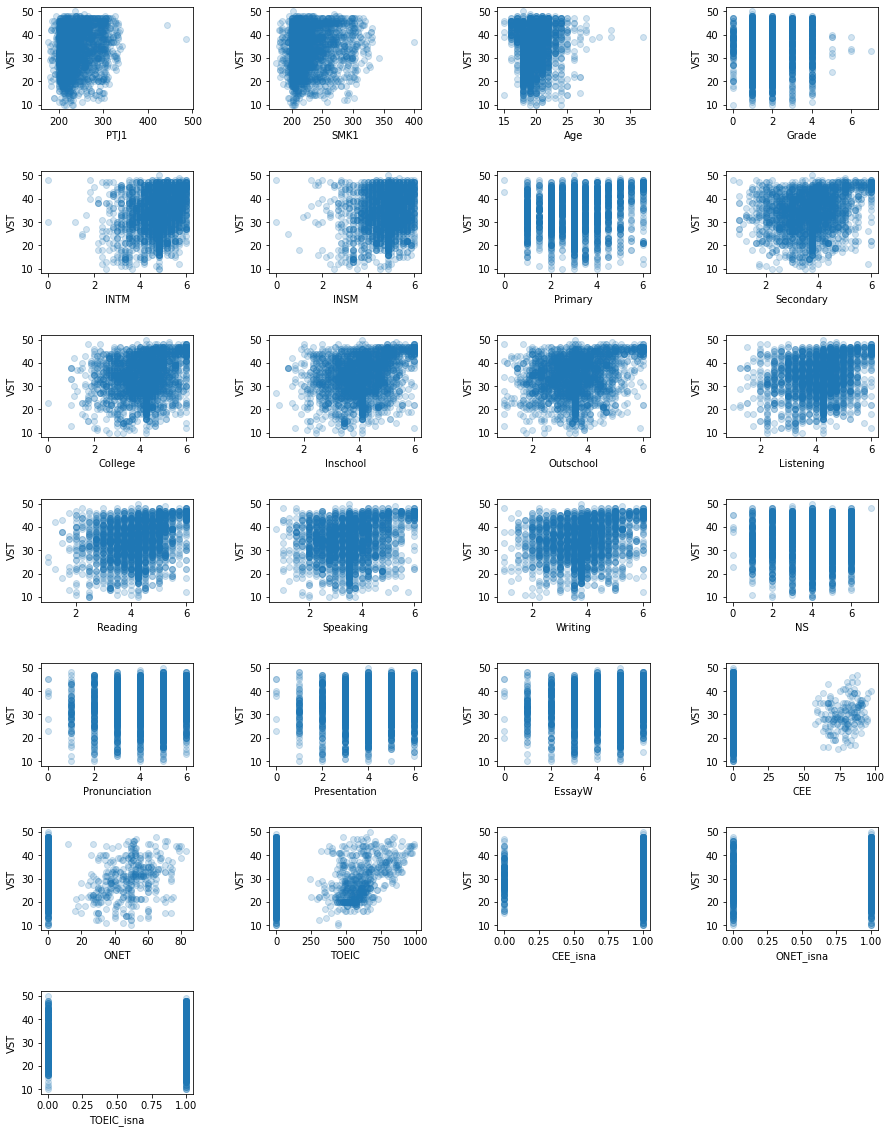

In [8]:
# Quick EDA for feature analysis.
scatterplots(columns = X.select_dtypes(include=np.number).columns, y_col = 'VST', data=df, ncol=4, figsize=(15, 20))

In [9]:
ce_hash = ce.HashingEncoder(cols=['Major'])
X = ce_hash.fit_transform(X)

C:\Users\jaeyo\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [10]:
# Get dummies
X = pd.get_dummies(X, dtype='int64')
X.shape

(2600, 54)

In [11]:
X.head()

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,PTJ1,SMK1,Age,Grade,INTM,INSM,Primary,Secondary,College,Inschool,Outschool,Listening,Reading,Speaking,Writing,NS,Pronunciation,Presentation,EssayW,CEE,ONET,TOEIC,CEE_isna,ONET_isna,TOEIC_isna,Country_CHN,Country_HKG,Country_IDN,Country_JPN,Country_KOR,Country_PAK,Country_PHL,Country_SIN,Country_THA,Country_TWN,Sex_F,Sex_M,Field_Humanities,Field_Life Sciences,Field_N/A,Field_Sciences & Technology,Field_Social Sciences,CEFR_A2_0,CEFR_B1_1,CEFR_B1_2,CEFR_B2_0
0,0,1,0,0,0,0,0,0,271,219,20,2.0,0.00,0.00,2.0,3.63,4.25,3.89,3.56,4.00,4.50,3.50,3.75,4.0,5.0,5.0,4.0,72.0,0.0,0.0,0,1,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0
1,0,1,0,0,0,0,0,0,203,292,21,3.0,4.17,4.33,2.5,4.00,1.86,3.00,2.88,3.00,3.00,2.75,3.33,3.0,3.0,3.0,3.0,77.0,0.0,0.0,0,1,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0
2,0,1,0,0,0,0,0,0,238,250,20,3.0,5.17,5.17,3.5,4.25,4.25,4.22,4.11,5.00,4.00,3.75,4.25,4.0,5.0,5.0,5.0,79.0,0.0,0.0,0,1,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0
3,0,0,0,0,0,1,0,0,269,230,20,2.0,4.67,5.17,1.0,2.75,4.25,3.44,3.00,3.75,3.75,3.25,3.25,3.0,5.0,5.0,5.0,87.0,0.0,0.0,0,1,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0
4,0,0,0,0,0,1,0,0,225,208,20,2.0,5.17,5.33,2.0,3.63,4.88,4.33,3.67,5.00,5.00,3.25,3.75,3.0,5.0,5.0,5.0,84.0,0.0,0.0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0


In [12]:
# Train Test split. Check their shapes and types
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
print(type(X_train), type(X_test), type(y_train), type(y_test))

(1950, 54) (650, 54) (1950,) (650,)
<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.frame.DataFrame'> <class 'pandas.core.series.Series'> <class 'pandas.core.series.Series'>


In [13]:
X_train = X_train.copy()
X_test = X_test.copy()

In [14]:
ptransform = PowerTransformer()

for col in ['PTJ1', 'SMK1']:
    ptransform.fit(X_train[[col]])
    X_train[col] = ptransform.transform(X_train[[col]])
    X_test[col] = ptransform.transform(X_test[[col]])

In [15]:
scaler = MinMaxScaler()

for col in ['CEE', 'ONET', 'TOEIC']:
    scaler.fit(X_train[[col]])
    X_train[col] = scaler.transform(X_train[[col]])
    X_test[col] = scaler.transform(X_test[[col]])

In [16]:
def lgb_eval(num_leaves,max_depth,lambda_l2,lambda_l1,min_child_samples, min_data_in_leaf, learning_rate):
    params = {
        "objective" : "regression",
        "metric" : "l1", 
        "num_leaves" : int(num_leaves),
        "max_depth" : int(max_depth),
        "lambda_l2" : lambda_l2,
        "lambda_l1" : lambda_l1,
        "num_threads" : 20,
        "min_child_samples" : int(min_child_samples),
        'min_data_in_leaf': int(min_data_in_leaf),
        "learning_rate" : 10 ** learning_rate,
        "subsample_freq" : 5,
        "bagging_seed" : 42,
        "verbosity" : -1
    }
    lgtrain = lgb.Dataset(X_train, y_train)
    cv_result = lgb.cv(params,
                       lgtrain,
                       1000,
                       early_stopping_rounds=100,
                       stratified=True,
                       nfold=10)
    result = 1/(cv_result['l1-mean'][-1])
    return result

In [27]:
lgbBO = BayesianOptimization(lgb_eval, {
    'num_leaves': (25, 10000),
    'max_depth': (5, 1000),
    'lambda_l2': (0.0, 0.5),
    'lambda_l1': (0.0, 0.5),
    'min_child_samples': (50, 10000),
    'min_data_in_leaf': (20, 2000),
    'learning_rate': (-3, 0)
})

lgbBO.maximize(n_iter=30, init_points=2)

|   iter    |  target   | lambda_l1 | lambda_l2 | learni... | max_depth | min_ch... | min_da... | num_le... |
-------------------------------------------------------------------------------------------------------------
[LightGBM] [Warning] min_data_in_leaf is set=1116, min_child_samples=181 will be ignored. Current value: min_data_in_leaf=1116
|  1        |  0.02971  |  0.1191   |  0.2692   | -1.405    |  624.2    |  181.0    |  1.117e+0 |  4.063e+0 |
|  2        |  0.02971  |  0.1611   |  0.05791  | -2.02     |  690.0    |  4.803e+0 |  1.577e+0 |  1.548e+0 |


C:\Users\jaeyo\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\jaeyo\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\jaeyo\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\jaeyo\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


|  3        |  0.02971  |  0.2287   |  0.1068   | -2.357    |  801.1    |  9.989e+0 |  1.54e+03 |  9.981e+0 |
|  4        |  0.3296   |  0.2666   |  0.3435   | -1.861    |  187.9    |  9.809e+0 |  45.55    |  497.2    |


C:\Users\jaeyo\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


|  5        |  0.3294   |  0.1636   |  0.3181   | -1.745    |  983.1    |  4.599e+0 |  79.77    |  8.591e+0 |
|  6        |  0.02971  |  0.2083   |  0.07904  | -2.872    |  155.5    |  6.394e+0 |  1.618e+0 |  8.054e+0 |


C:\Users\jaeyo\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\jaeyo\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


|  7        |  0.2195   |  0.2514   |  0.4035   | -0.5792   |  119.5    |  8.855e+0 |  421.8    |  3.717e+0 |


C:\Users\jaeyo\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


|  8        |  0.1962   |  0.4663   |  0.4211   | -2.761    |  73.01    |  4.789e+0 |  328.7    |  8.976e+0 |
|  9        |  0.02971  |  0.2968   |  0.1493   | -1.844    |  614.0    |  8.067e+0 |  1.59e+03 |  7.89e+03 |


C:\Users\jaeyo\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\jaeyo\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


|  10       |  0.3012   |  0.0      |  0.0      |  0.0      |  1e+03    |  3.099e+0 |  20.0     |  8.375e+0 |
|  11       |  0.02971  |  0.2344   |  0.4579   | -2.467    |  165.0    |  9.637e+0 |  1.783e+0 |  9.5e+03  |


C:\Users\jaeyo\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\jaeyo\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\jaeyo\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


|  12       |  0.02971  |  0.0      |  0.0      |  0.0      |  1e+03    |  9.878e+0 |  2e+03    |  419.2    |
|  13       |  0.2031   |  0.39     |  0.3411   | -1.466    |  680.7    |  3.723e+0 |  542.8    |  8.864e+0 |


C:\Users\jaeyo\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


|  14       |  0.3188   |  0.2543   |  0.2342   | -1.153    |  846.2    |  3.117e+0 |  135.2    |  8.148e+0 |


C:\Users\jaeyo\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


|  15       |  0.02971  |  0.1107   |  0.08927  | -0.2221   |  254.6    |  5.387e+0 |  885.3    |  6.869e+0 |


C:\Users\jaeyo\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


|  16       |  0.3154   |  0.4158   |  0.249    | -0.2335   |  565.7    |  9.983e+0 |  37.49    |  1.968e+0 |


C:\Users\jaeyo\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


|  17       |  0.3273   |  0.2949   |  0.02193  | -2.138    |  21.62    |  5.501e+0 |  26.19    |  2.689e+0 |


C:\Users\jaeyo\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


|  18       |  0.2414   |  0.0      |  0.5      | -3.0      |  5.0      |  7.234e+0 |  20.0     |  2.269e+0 |


C:\Users\jaeyo\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


|  19       |  0.3264   |  0.4051   |  0.1591   | -1.059    |  572.0    |  2.263e+0 |  23.19    |  6.975e+0 |
|  20       |  0.02971  |  0.4476   |  0.05439  | -0.162    |  433.4    |  6.827e+0 |  1.928e+0 |  712.8    |


C:\Users\jaeyo\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\jaeyo\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


|  21       |  0.2033   |  0.4976   |  0.2692   | -1.322    |  747.6    |  2.626e+0 |  544.4    |  7.19e+03 |


C:\Users\jaeyo\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


|  22       |  0.2421   |  0.0      |  0.0      | -3.0      |  5.0      |  1.507e+0 |  20.0     |  7.829e+0 |


C:\Users\jaeyo\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


|  23       |  0.2414   |  0.5      |  0.5      | -3.0      |  5.0      |  5.993e+0 |  20.0     |  3.833e+0 |


C:\Users\jaeyo\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


|  24       |  0.2439   |  0.5      |  0.5      | -3.0      |  977.1    |  8.874e+0 |  20.0     |  1.234e+0 |
|  25       |  0.02971  |  0.4459   |  0.4677   | -1.816    |  879.8    |  8.983e+0 |  1.39e+03 |  4.52e+03 |


C:\Users\jaeyo\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\jaeyo\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


|  26       |  0.3276   |  0.0      |  0.0      | -0.6731   |  5.0      |  4.27e+03 |  20.0     |  3.466e+0 |


C:\Users\jaeyo\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


|  27       |  0.02971  |  0.3367   |  0.2844   | -1.645    |  79.49    |  7.285e+0 |  905.7    |  9.949e+0 |


C:\Users\jaeyo\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


|  28       |  0.2114   |  0.0502   |  0.06392  | -1.026    |  294.2    |  3.035e+0 |  474.5    |  8.563e+0 |


C:\Users\jaeyo\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


|  29       |  0.2021   |  0.007096 |  0.3867   | -2.56     |  204.4    |  3.033e+0 |  388.0    |  8.592e+0 |


C:\Users\jaeyo\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


|  30       |  0.3151   |  0.09323  |  0.1913   | -1.442    |  173.8    |  9.714e+0 |  141.8    |  404.0    |


C:\Users\jaeyo\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


|  31       |  0.1389   |  0.1715   |  0.3191   | -2.348    |  97.62    |  2.903e+0 |  850.7    |  5.913e+0 |


C:\Users\jaeyo\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


|  32       |  0.2414   |  0.5      |  0.5      | -3.0      |  5.0      |  2.889e+0 |  20.0     |  2.466e+0 |


In [28]:
lgbBO.max

{'target': 0.32962803776642663,
 'params': {'lambda_l1': 0.26657153644156983,
  'lambda_l2': 0.34348148054394106,
  'learning_rate': -1.8612546812395063,
  'max_depth': 187.94763555611115,
  'min_child_samples': 9809.059457080562,
  'min_data_in_leaf': 45.55358067784044,
  'num_leaves': 497.20975580817714}}

In [29]:
opt_params = {
    "objective" : "regression",
        "metric" : "l1", 
        "num_leaves" : 497,
        "max_depth" : 187,
        "lambda_l2" : 0.34348148054394106,
        "lambda_l1" : 0.26657153644156983,
        "num_threads" : 20,
        "min_child_samples" : 9809,
        'min_data_in_leaf': 45,
        "learning_rate" : 10 ** -1.8612546812395063,
        "subsample_freq" : 5,
        "bagging_seed" : 42,
        "verbosity" : -1
}

lgtrain = lgb.Dataset(X_train, y_train)

In [30]:
lgb_best = lgb.train(opt_params, lgtrain, 1000)

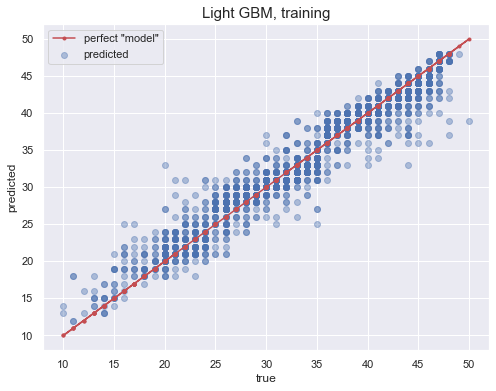

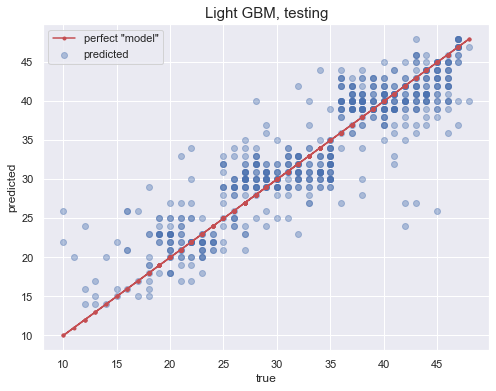

In [31]:
# Predict on Training and Test sets using Light GBM model
y_tr_lgb_pred = lgb_best.predict(X_train)
y_te_lgb_pred = lgb_best.predict(X_test)

# Plot predicted vs true
pred_plot("Light GBM, training", y_train, np.round(y_tr_lgb_pred))
pred_plot("Light GBM, testing", y_test, np.round(y_te_lgb_pred))

In [32]:
# Print test stats
test_stat("Light GBM", y_test, y_te_lgb_pred)

Light GBM : 
R^2:  0.8116
RMSE:  3.8125
MAE:  2.8359


In [59]:
def rf_eval(n_estimators, max_depth, max_features):
    rf = RandomForestRegressor(
        n_estimators = int(n_estimators),
        max_depth =  int(max_depth),
        max_features = int(max_features),
        n_jobs = -1, 
        random_state = 42
    )
    cv_score = cross_val_score(rf, X_train, y_train, cv=10, n_jobs=-1).mean()
    return cv_score

In [60]:
rfBO = BayesianOptimization(rf_eval, {
    'n_estimators': (10, 10000),
    'max_depth': (5, 100),
    'max_features': (3, len(X_train.columns))
})

rfBO.maximize(n_iter=30, init_points=2)

|   iter    |  target   | max_depth | max_fe... | n_esti... |
-------------------------------------------------------------
|  1        |  0.7884   |  60.35    |  42.27    |  3.49e+03 |
|  2        |  0.787    |  21.22    |  47.6     |  3.411e+0 |
|  3        |  0.7897   |  59.86    |  38.92    |  3.492e+0 |
|  4        |  0.7875   |  62.34    |  45.13    |  3.5e+03  |
|  5        |  0.7899   |  65.33    |  36.12    |  3.491e+0 |
|  6        |  0.7912   |  73.19    |  30.01    |  3.496e+0 |
|  7        |  0.7923   |  46.74    |  22.79    |  4.29e+03 |
|  8        |  0.7921   |  15.92    |  26.1     |  9.14e+03 |
|  9        |  0.7872   |  43.89    |  11.13    |  4.291e+0 |
|  10       |  0.7906   |  64.73    |  14.4     |  5.655e+0 |
|  11       |  0.7873   |  81.32    |  46.34    |  9.202e+0 |
|  12       |  0.7836   |  92.39    |  46.43    |  44.83    |
|  13       |  0.7801   |  7.296    |  51.91    |  9.072e+0 |
|  14       |  0.792    |  66.54    |  27.74    |  4.289e+0 |
|  15   

C:\Users\jaeyo\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


|  16       |  0.7921   |  14.6     |  27.73    |  9.139e+0 |
|  17       |  0.7922   |  60.29    |  18.37    |  3.484e+0 |
|  18       |  0.7905   |  54.51    |  14.65    |  3.501e+0 |
|  19       |  0.7872   |  81.16    |  11.15    |  3.481e+0 |
|  20       |  0.7917   |  58.94    |  28.08    |  4.27e+03 |
|  21       |  0.789    |  31.13    |  40.82    |  9.145e+0 |
|  22       |  0.7926   |  42.47    |  19.32    |  3.476e+0 |
|  23       |  0.7917   |  32.21    |  27.67    |  3.486e+0 |
|  24       |  0.7916   |  18.79    |  17.21    |  9.115e+0 |
|  25       |  0.7915   |  28.7     |  28.84    |  3.463e+0 |
|  26       |  0.738    |  6.487    |  11.17    |  9.125e+0 |
|  27       |  0.7914   |  36.09    |  16.77    |  9.119e+0 |
|  28       |  0.7918   |  26.83    |  28.09    |  9.117e+0 |


C:\Users\jaeyo\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


|  29       |  0.7704   |  28.62    |  6.917    |  3.471e+0 |
|  30       |  0.7912   |  50.24    |  30.4     |  3.476e+0 |
|  31       |  0.7891   |  33.68    |  39.46    |  3.475e+0 |
|  32       |  0.7925   |  23.75    |  19.31    |  9.095e+0 |


In [26]:
rfBO.max

{'target': 0.7797387169478314,
 'params': {'max_depth': 93.78665790920121,
  'max_features': 19.25045298717707,
  'n_estimators': 7990.104108732048}}

In [62]:
rf_best = RandomForestRegressor(
    n_estimators = 7990,
    max_depth = 93,
    max_features = 19,
    n_jobs = -1,
    random_state = 42
)
rf_best.fit(X_train, y_train)

RandomForestRegressor(max_depth=93, max_features=19, n_estimators=7990,
                      n_jobs=-1, random_state=42)

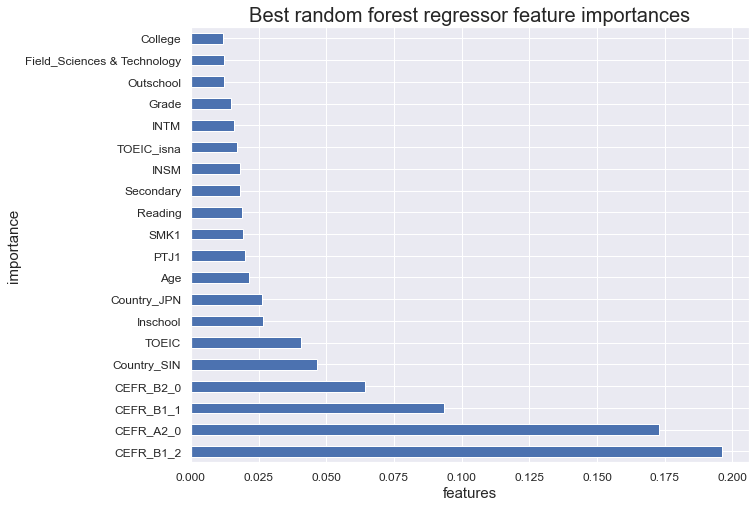

In [63]:
# Plot the top 20 feature importances.
plt.subplots(figsize=(10, 8))
imps = rf_best.feature_importances_
rf_feat_imps = pd.Series(imps, index=X_train.columns).sort_values(ascending=False)[:20]
_ = rf_feat_imps.plot(kind='barh', fontsize=12)
_ = plt.xlabel('features', fontsize=15)
_ = plt.ylabel('importance', fontsize=15)
_ = plt.title('Best random forest regressor feature importances', fontsize=20);
plt.show()

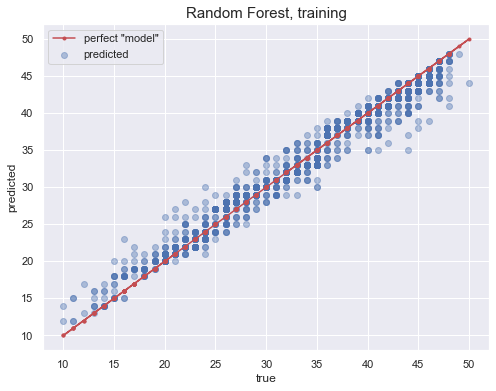

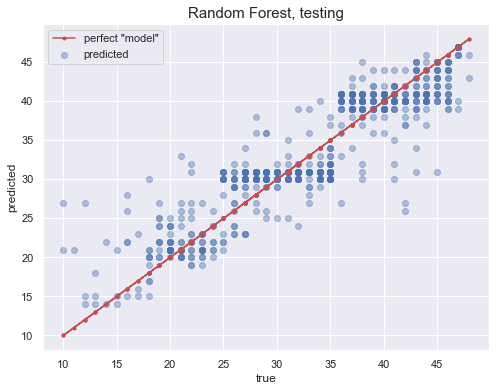

In [64]:
# Predict on Training and Test sets using Random Forest model
y_tr_rf_pred = rf_best.predict(X_train)
y_te_rf_pred = rf_best.predict(X_test)

# Plot predicted vs true
pred_plot("Random Forest, training", y_train, np.round(y_tr_rf_pred))
pred_plot("Random Forest, testing", y_test, np.round(y_te_rf_pred))

In [65]:
# Print test stats
test_stat("Random Forest", y_test, y_te_rf_pred)

Random Forest : 
R^2:  0.8306
RMSE:  3.6156
MAE:  2.7208


In [48]:
xgb.set_config(verbosity=0)

def xg_eval(n_estimators, max_depth, min_child_weight, learning_rate, gamma, num_boost_round):
    xg = XGBRegressor(
        objective = 'reg:linear',
        n_estimators = int(n_estimators),
        max_depth =  int(max_depth),
        min_child_weight = int(min_child_weight),
        learning_rate = 10 ** learning_rate,
        gamma = 10 ** gamma,
        num_boost_round = int(10 ** num_boost_round),
        early_stopping_rounds = 100,
        seed = 42
    )
    cv_score = cross_val_score(xg, X_train, y_train, cv=10, n_jobs=-1).mean()
    return cv_score

In [49]:
xgBO = BayesianOptimization(xg_eval, {
    'n_estimators': (10, 1000),
    'max_depth': (10, 50),
    'min_child_weight': (1, 20),
    'learning_rate': (-4, 0),
    'gamma': (-3, 1), 
    'num_boost_round': (1, 4)
})

xgBO.maximize(n_iter=30, init_points=2)

|   iter    |  target   |   gamma   | learni... | max_depth | min_ch... | n_esti... | num_bo... |
-------------------------------------------------------------------------------------------------
|  1        | -0.5815   | -1.322    | -2.522    |  28.27    |  15.98    |  414.0    |  677.0    |
|  2        |  0.6952   | -0.8096   | -0.3075   |  42.19    |  14.5     |  660.0    |  8.61e+03 |
|  3        |  0.7492   | -2.006    | -1.622    |  47.26    |  19.36    |  666.2    |  8.603e+0 |
|  4        | -12.35    | -3.0      | -4.0      |  50.0     |  20.0     |  825.7    |  8.417e+0 |
|  5        |  0.6116   | -1.315    | -0.03017  |  28.89    |  14.32    |  408.5    |  681.4    |
|  6        |  0.7439   | -1.25     | -1.658    |  43.4     |  7.21     |  349.1    |  752.4    |
|  7        |  0.7274   | -2.944    | -0.6171   |  27.71    |  15.1     |  325.7    |  666.1    |
|  8        | -13.15    |  0.8961   | -3.929    |  47.85    |  7.62     |  446.4    |  781.6    |
|  9        |  0.622

In [22]:
xgBO.max

{'target': 0.7666997556177615,
 'params': {'gamma': -2.4055111476992774,
  'learning_rate': -2.177310112477809,
  'max_depth': 49.925855871905036,
  'min_child_weight': 5.568764031651191,
  'n_estimators': 717.4229567602068,
  'num_boost_round': 3.677119153773835}}

In [23]:
xg_best = XGBRegressor(
    objective = 'reg:linear',
    n_estimators = 717,
    max_depth = 49,
    min_child_weight = 5,
    learning_rate = 10 ** -2.177310112477809,
    gamma = 10 ** -2.4055111476992774,
    num_boost_round = int(10 ** 3.677119153773835),
    seed = 42
)
xg_best.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0.003930871548100457,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.006647982805717456, max_delta_step=0, max_depth=49,
             min_child_weight=5, missing=nan, monotone_constraints='()',
             n_estimators=717, n_jobs=8, num_boost_round=4754,
             num_parallel_tree=1, objective='reg:linear', random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

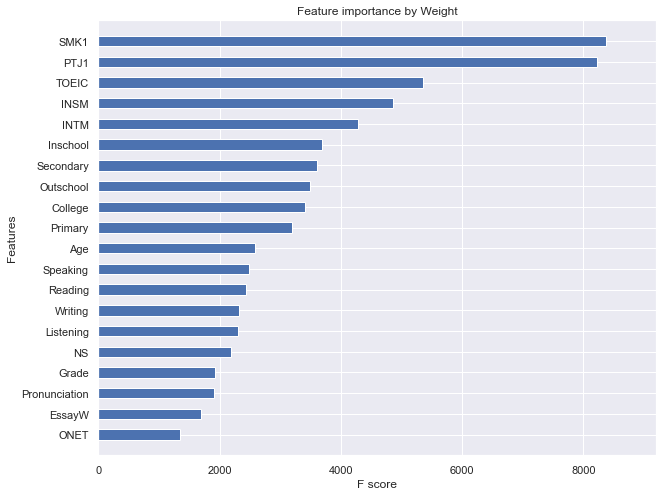

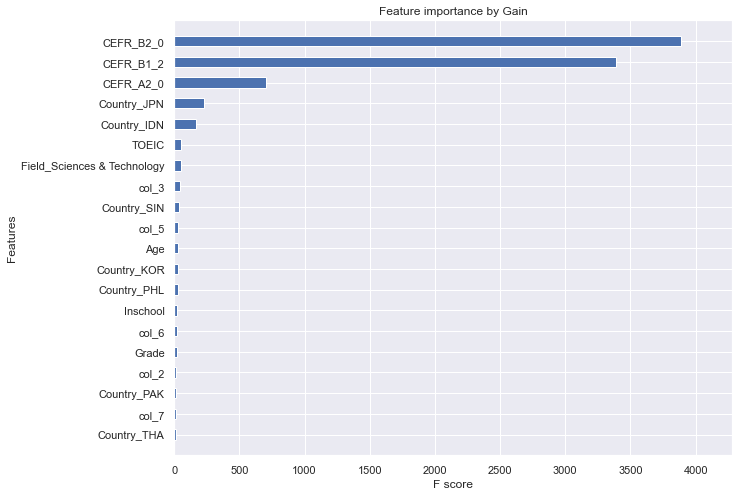

In [68]:
# Plot top 20 feature importances of XG Boost model. Importance type 'weight' and 'gain' show completely different results. Plot both
fig, ax = plt.subplots(figsize=(10,8))
xgb.plot_importance(xg_best, importance_type = 'weight', ax=ax, title='Feature importance by Weight', 
                    height=0.5, max_num_features=20, show_values=False)
plt.show()

fig, ax = plt.subplots(figsize=(10,8))
xgb.plot_importance(xg_best, importance_type = 'gain', ax=ax, title='Feature importance by Gain', 
                    height=0.5, max_num_features=20, show_values=False)
plt.show()

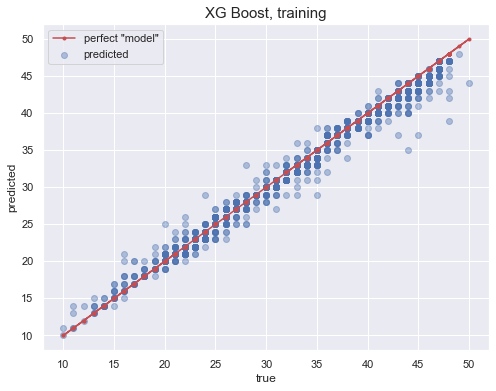

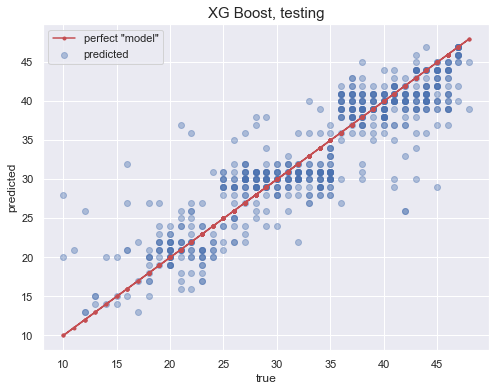

In [24]:
# Predict on Training and Test sets using Light GBM model
y_tr_xg_pred = xg_best.predict(X_train)
y_te_xg_pred = xg_best.predict(X_test)

# Plot predicted vs true
pred_plot("XG Boost, training", y_train, np.round(y_tr_xg_pred))
pred_plot("XG Boost, testing", y_test, np.round(y_te_xg_pred))

In [25]:
# Print test stats
test_stat("XG Boost", y_test, y_te_xg_pred)

XG Boost : 
R^2:  0.8097
RMSE:  3.8322
MAE:  2.8538


In [50]:
# Initialize pipeline for optional StandardScaler followed by Lasso regression
scaler = StandardScaler()
lasso = Lasso(random_state=42)
pipe = make_pipeline(scaler, lasso)

# Parameter grid for pipeline - scaler is optional.
params = {
    'standardscaler': [StandardScaler(), None],
    'lasso__alpha': [n for n in np.logspace(-6,0,13)],
    'lasso__max_iter': [1000, 10000]
}

# 3-fold CV Grid Search, fit, and print CV test results for top five estimators. Commented out for run-through
lasso_grid_cv = GridSearchCV(pipe, params, cv=10, n_jobs=-1)
lasso_grid_cv.fit(X_train, y_train)
print(lasso_grid_cv.best_params_)
pd.DataFrame(lasso_grid_cv.cv_results_).sort_values('mean_test_score', ascending=False)[0:5]

{'lasso__alpha': 0.00031622776601683794, 'lasso__max_iter': 10000, 'standardscaler': None}


C:\Users\jaeyo\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15494.58246394097, tolerance: 14.61748517948718
  model = cd_fast.enet_coordinate_descent(


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_lasso__alpha,param_lasso__max_iter,param_standardscaler,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
23,1.962718,0.119691,0.006895,0.004104,0.000316,10000,None,"{'lasso__alpha': 0.00031622776601683794, 'lass...",0.754200,0.692574,0.615186,0.733152,0.674565,0.762555,0.718007,0.720729,0.612214,0.777092,0.706027,0.054668,1
22,1.878275,0.138912,0.005050,0.000569,0.000316,10000,StandardScaler(),"{'lasso__alpha': 0.00031622776601683794, 'lass...",0.754050,0.692671,0.615064,0.733052,0.674570,0.762440,0.717876,0.720942,0.612251,0.777235,0.706015,0.054671,2
19,1.932495,0.097583,0.005192,0.001141,0.0001,10000,None,"{'lasso__alpha': 0.0001, 'lasso__max_iter': 10...",0.753956,0.692358,0.615349,0.732947,0.674388,0.762532,0.717512,0.721035,0.611965,0.777290,0.705933,0.054688,3
18,1.985174,0.222665,0.004605,0.000659,0.0001,10000,StandardScaler(),"{'lasso__alpha': 0.0001, 'lasso__max_iter': 10...",0.753906,0.692370,0.615305,0.732913,0.674387,0.762492,0.717467,0.721086,0.611978,0.777333,0.705924,0.054689,4
15,1.897976,0.139841,0.007250,0.008263,0.000032,10000,None,"{'lasso__alpha': 3.1622776601683795e-05, 'lass...",0.753871,0.692207,0.615392,0.732875,0.674325,0.762515,0.717344,0.720857,0.611882,0.777341,0.705861,0.054688,5


In [51]:
# Set lasso_best to alpha=0.000316, max_iter=10000. Fit to training set.
lasso_best = Lasso(alpha=0.00031623, max_iter=10000, random_state=42)
lasso_best.fit(X_train, y_train)

C:\Users\jaeyo\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15494.558623868379, tolerance: 14.61748517948718
  model = cd_fast.enet_coordinate_descent(


Lasso(alpha=0.00031623, max_iter=10000, random_state=42)

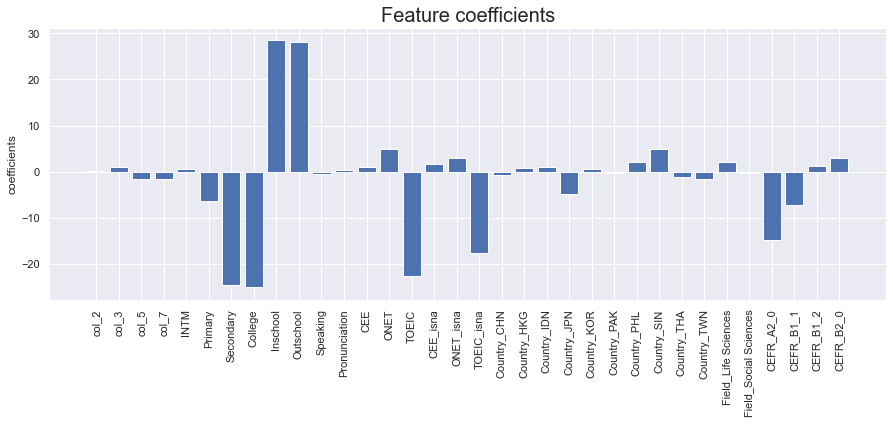

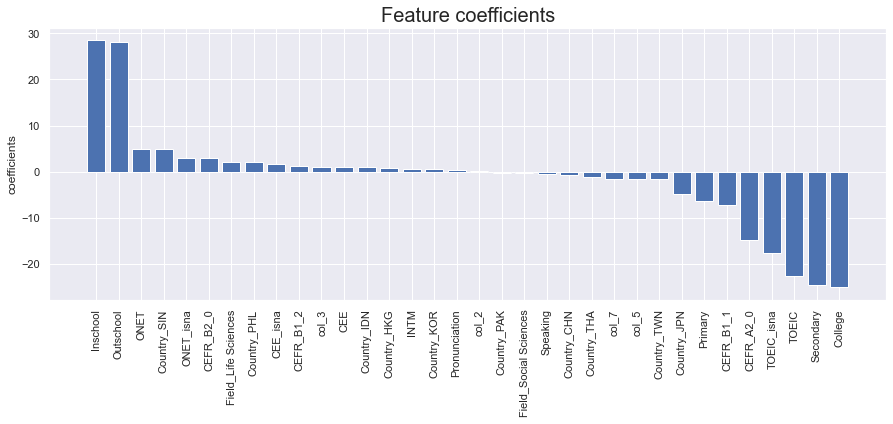

In [57]:
# For plotting purposes - keep only the coefficients of absolute value > 0.2 to keep the plot visually comprehensible
lasso_coefs = pd.DataFrame(lasso_best.coef_, index=X_train.columns, columns=['coef'])
lasso_coefs = lasso_coefs[abs(lasso_coefs.coef) > 0.2]

# Plot feature coefficients of Lasso regression
fig, ax = plt.subplots(figsize=(15,5))
ax.bar(lasso_coefs.index, lasso_coefs.coef)
plt.xticks(rotation='vertical')
plt.ylabel('coefficients')
plt.title('Feature coefficients', fontsize=20)
plt.show()

# Plot feature coefficients of Lasso regression, sorted
lasso_coefs_sorted = lasso_coefs.sort_values('coef', ascending=False)
fig, ax = plt.subplots(figsize=(15,5))
ax.bar(lasso_coefs_sorted.index, lasso_coefs_sorted.coef)
plt.xticks(rotation='vertical')
plt.ylabel('coefficients')
plt.title('Feature coefficients', fontsize=20)
plt.show()

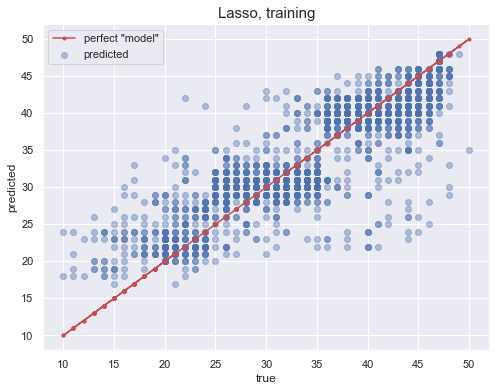

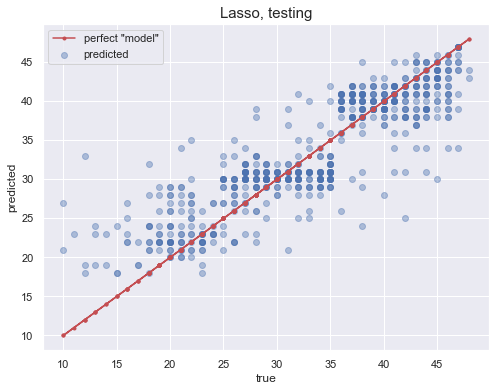

In [58]:
# Predict Testing and Test sets using Lasso regression
y_tr_lasso_pred = lasso_best.predict(X_train)
y_te_lasso_pred = lasso_best.predict(X_test)

# Plot predicted vs true
pred_plot("Lasso, training", y_train, np.round(y_tr_lasso_pred))
pred_plot("Lasso, testing", y_test, np.round(y_te_lasso_pred))

In [59]:
# Print test stats for Lasso
test_stat("Lasso", y_test, y_te_lasso_pred)

Lasso : 
R^2:  0.7682
RMSE:  4.2288
MAE:  3.1313


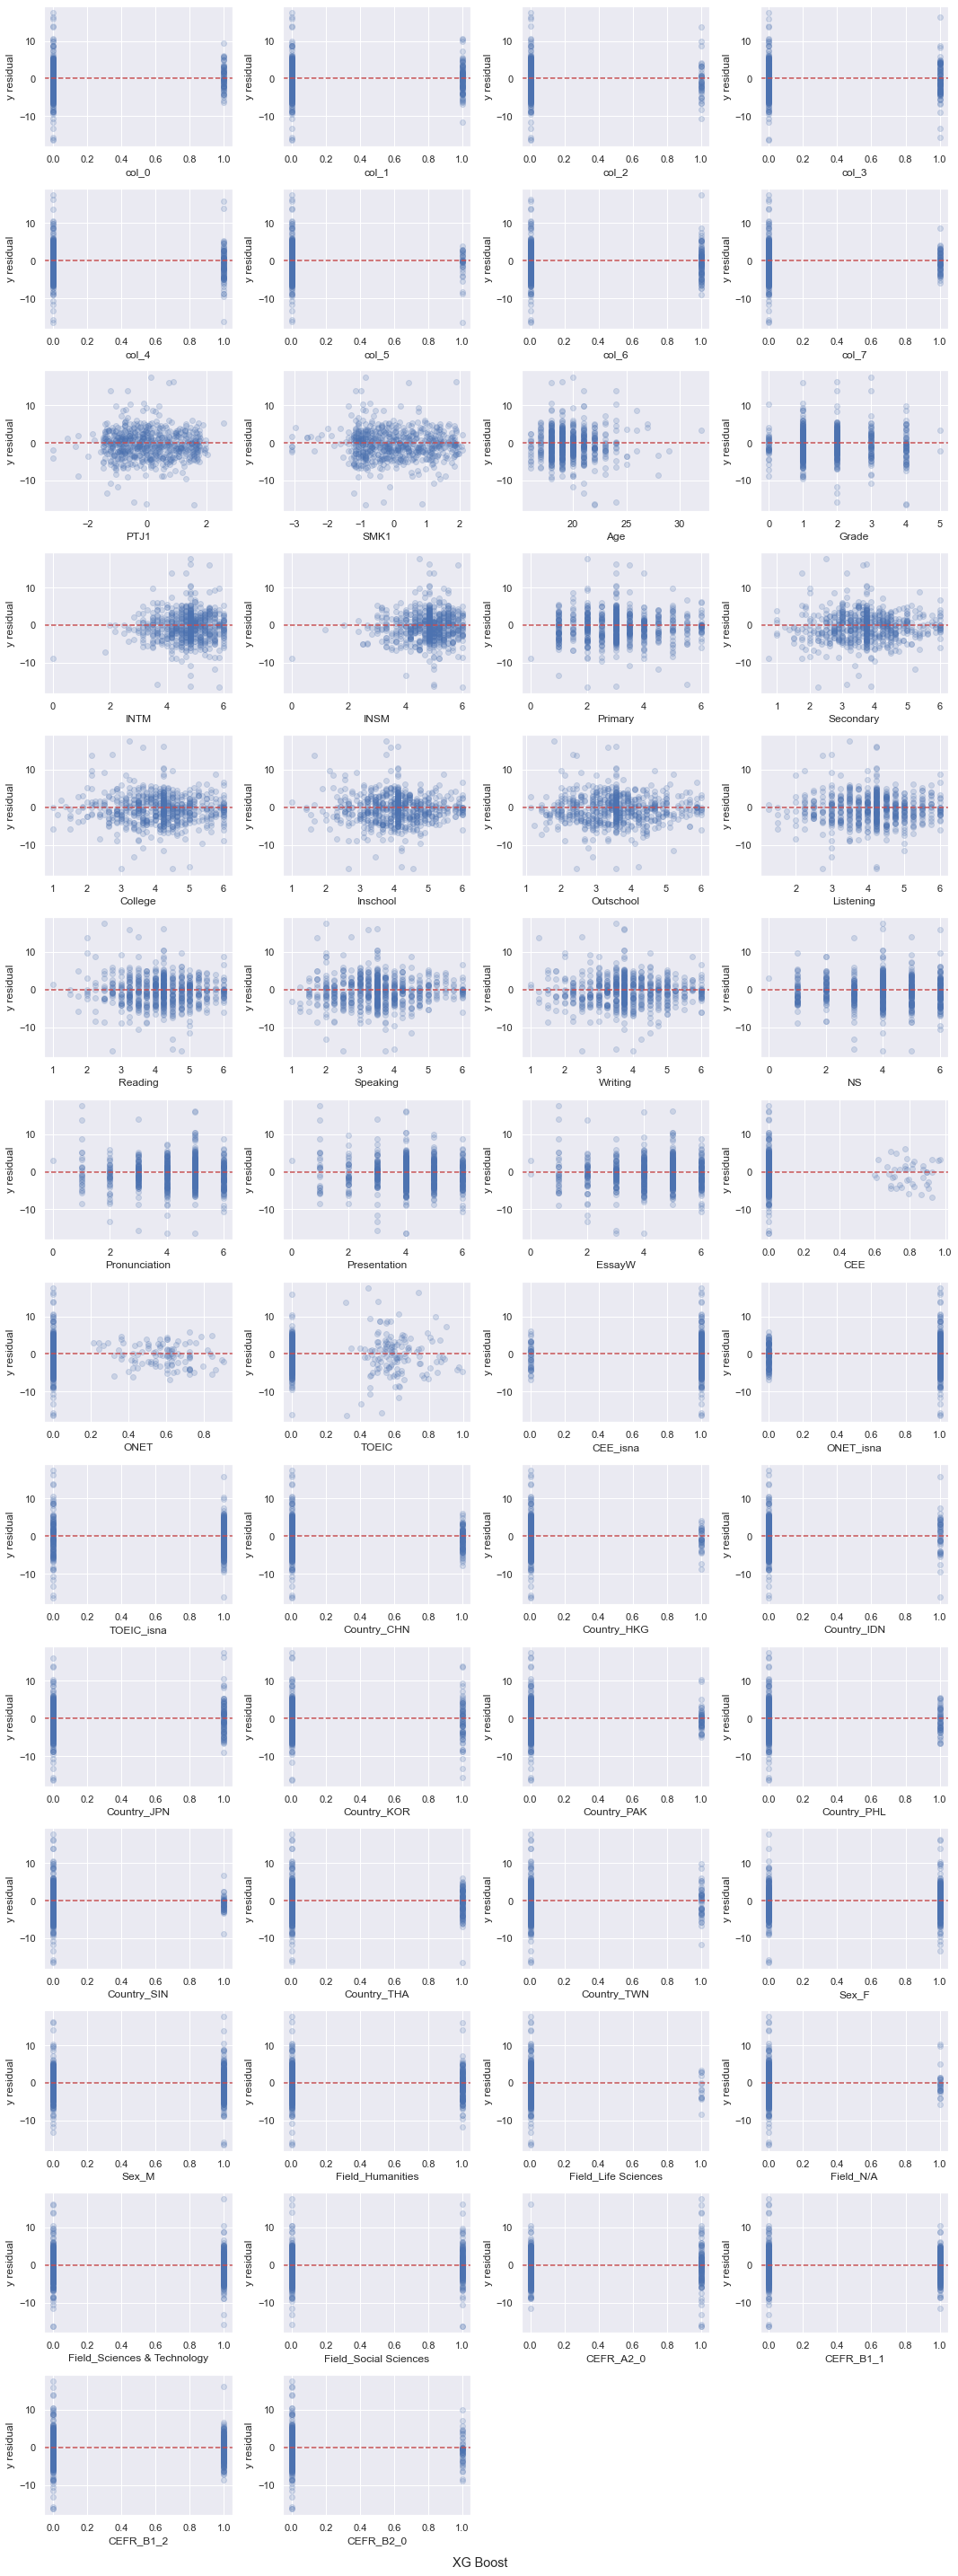

In [60]:
# XG Boost Testing prediction residuals
res_plot('XG Boost', X_test, y_test, y_te_xg_pred, ncol=4, figsize=(15,40))

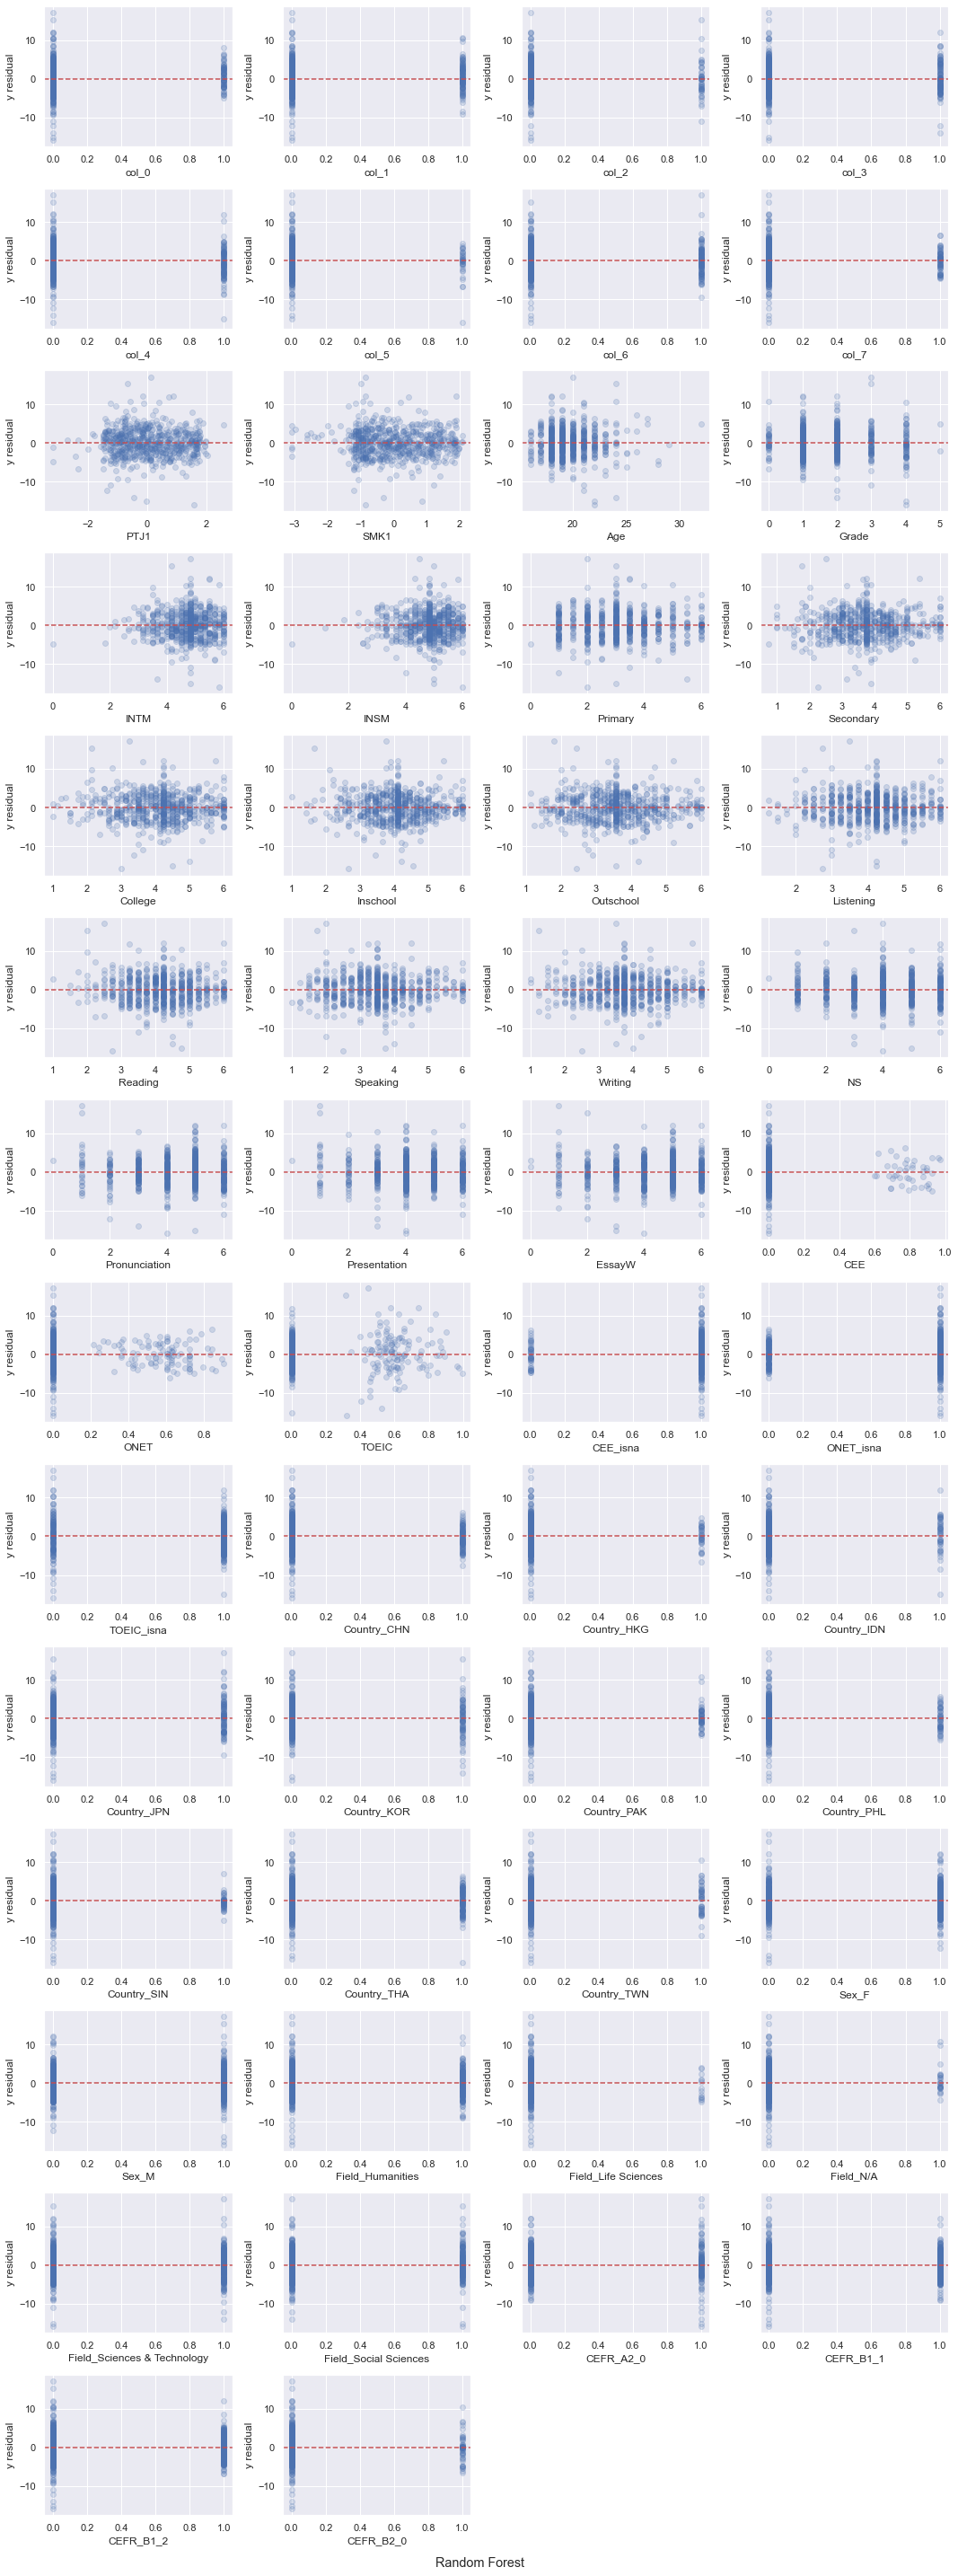

In [66]:
# Random Forest Testing prediction residuals
res_plot('Random Forest', X_test, y_test, y_te_rf_pred, ncol=4, figsize=(15,40))

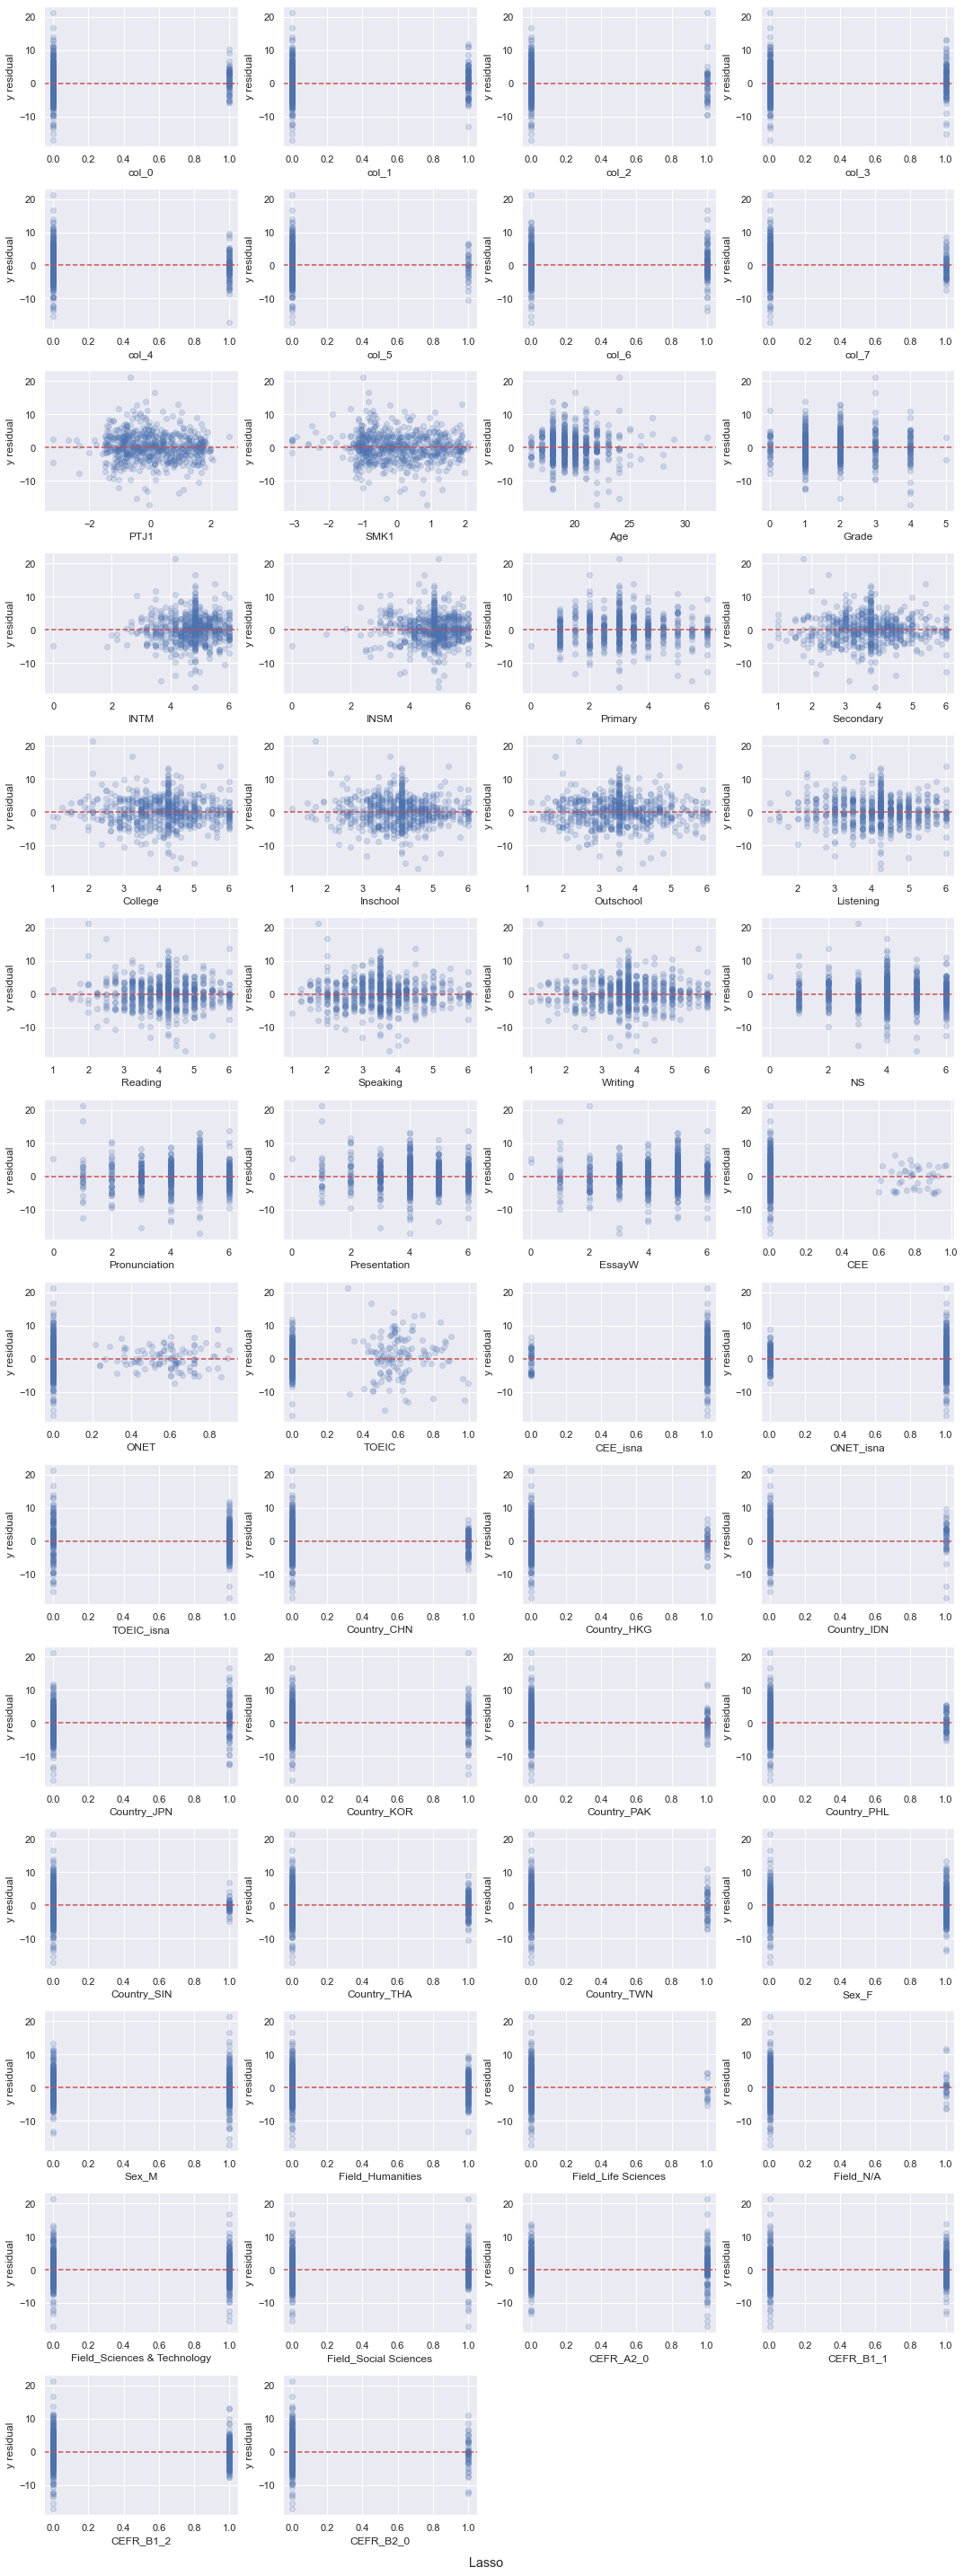

In [67]:
# Lasso Testing prediction residuals
res_plot('Lasso', X_test, y_test, y_te_lasso_pred, ncol=4, figsize=(15,40))